# Grabbing the Data

The dataset below will be the one I use for this blog post

In [282]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df = pd.read_csv(url)

In [283]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


## Visualizations of the Data



For the dataset, I created two plots and one summary table in order to contextualize the data. 

In [284]:
from matplotlib import pyplot as plt
import seaborn as sns


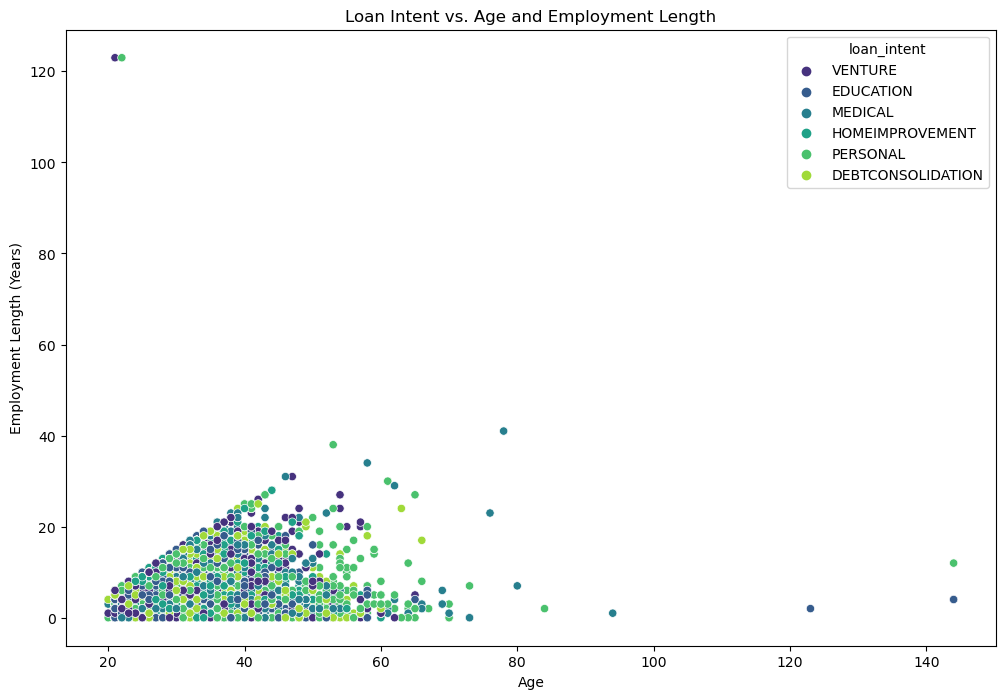

In [286]:
#| label: fig-scatter-loan
#| fig-cap: Loan Intent 

plt.figure(figsize=(12, 8))
sns.scatterplot(x='person_age', y='person_emp_length', hue='loan_intent', data=df, palette='viridis')
plt.title('Loan Intent vs. Age and Employment Length')
plt.xlabel('Age')
plt.ylabel('Employment Length (Years)')
plt.show()

Regarding @fig-scatter-loan, we can see some patterns within the dataset among loan intentions. 

Most notably in the bottom left corner of the plot, which indicates both a young age and limited employment history, there is a culmination of both Educational and Venture loans being used. 

This makes sense given the current context of the world, as young individuals would most likely be in college or other forms of education at this time. On a similar note, venture capital is often used for newly formed or aspiring companies. Hence, the youthful age and lack of employment history match.

Conversely, as age increases, loans for medical, home improvement, and debt consolidation become more likely. This evidence is runs concurrent with today's societal concerns from our more elderly population. 

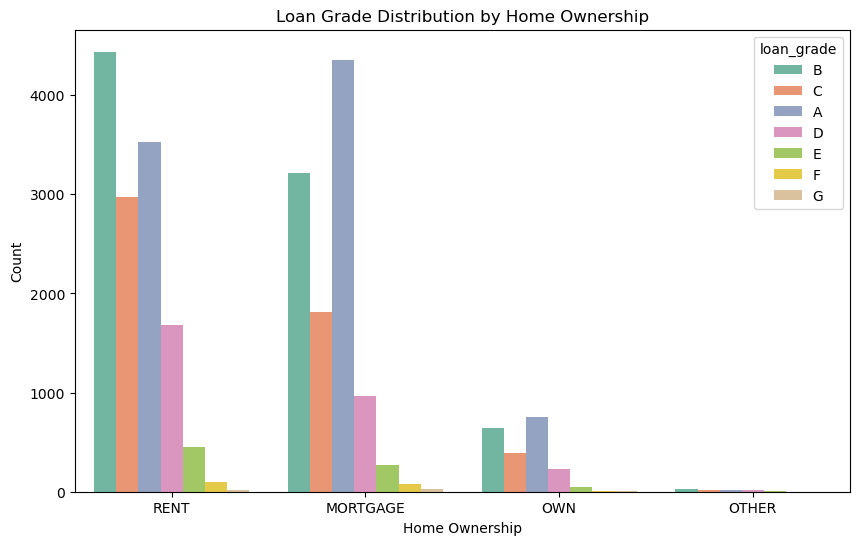

In [287]:
#| label: fig-scatter-loan-grade
#| fig-cap: Loan Grade Distribution by Home Ownership

plt.figure(figsize=(10, 6))
sns.countplot(x='person_home_ownership', hue='loan_grade', data=df, palette='Set2')
plt.title('Loan Grade Distribution by Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.show()

@fig-scatter-loan-grade illustrates the Loan grade distribution by home ownership. Loan Grade is viewed A-G with A being the highest loan grade and G being the lowest. 

An interesting observation to make here is that for individuals in both the 'Mortgage' and 'Home' groups, the highest frequency of loans is rated as an A whereas for individuals in the 'Rent' group the highest frequency of loans is rated as an B.

This could give context to the economic state of home ownership and bank trust. Those with a mortgage/own property could perhaps be linked to being more trustworthy due to having a longer term connection with a property. Banks may view those in the 'Rent' category as a bit more risky due to the short term ability of renting.

In [126]:
summary_table = df.groupby('loan_intent').agg({
    'loan_int_rate': 'mean',
    'loan_amnt': 'mean'
}).reset_index()

summary_table.rename(columns={
    'loan_int_rate': 'Average Interest Rate',
    'loan_amnt': 'Average Loan Amount'
}, inplace=True)

print(summary_table)


         loan_intent  Average Interest Rate  Average Loan Amount
0  DEBTCONSOLIDATION              10.983305          9620.901149
1          EDUCATION              10.965465          9460.015604
2    HOMEIMPROVEMENT              11.160075         10348.725017
3            MEDICAL              11.051946          9242.269907
4           PERSONAL              11.009814          9549.427178
5            VENTURE              10.940866          9516.417425


This summary table above displays the relative average interest rates and average loan amounts for each category of loan intent.

Home improvement has the greatest average loan amount while similarly having the highest interest rate. On the flip side, education has the lowest average loan amount but the second lowest interest rate.

## Part C: Build a Model

I will be utilizing a Logistic Regression Model for predicting whether a prospective borrower is likely to default on a given loan. 

I will also be utilizing the `RFECV` class from `sklearn` in order to automatically find the most useful features to use in the model. RFE is a feature selection method that fits a model and removes the weakest feature(s) until the specified number of features is reached. Using RFE, you can automate the process of finding an effective subset of features.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline


url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_all = pd.read_csv(url)

df = df_all.drop(['loan_grade', 'loan_status'], axis=1)  
df = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'cb_person_default_on_file'], drop_first=True)
df.dropna(inplace=True)

y = df_all.loc[df.index, 'loan_status']  

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=123)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=1000)

selector = RFECV(estimator=logreg, step=1, cv=5)
selector = selector.fit(X_train_scaled, y_train)  # Fitting RFECV to the scaled training data


X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

model_selected = LogisticRegression(max_iter=1000)
model_selected.fit(X_train_selected, y_train)

selected_features = X_train.columns[selector.support_]

# Prediction
y_pred_selected = model_selected.predict(X_test_selected)
print(f"Optimal number of features: {selector.n_features_}")
print(classification_report(y_test, y_pred_selected))


Optimal number of features: 8
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      3614
           1       0.68      0.48      0.56       968

    accuracy                           0.84      4582
   macro avg       0.77      0.71      0.73      4582
weighted avg       0.83      0.84      0.83      4582



The code below is used to identify which features will be used for the most optimal model prediction.

In [255]:
feature_names = df.columns

selected_features = feature_names[selector.support_]

print("Selected features:", selected_features)


Selected features: Index(['loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_EDUCATION', 'loan_intent_PERSONAL', 'loan_intent_VENTURE'],
      dtype='object')


In [6]:

X = df[selected_features]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## MODEL HERE
model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000)

In [28]:
# Predict probabilities
X_train['probabilities'] = model.predict_proba(X_train_scaled)[:, 1]

X_train['actual'] = y_train
X_train['prediction_probability'] = probabilities

In [29]:
# profit/loss calculation
def calculate_gain_loss(row):
    if row['predicted_issued']:
        if row['actual'] == 1:
            return row['loan_amnt'] * (1 + 0.25 * row['loan_int_rate'])**10 - row['loan_amnt']
        else:
            return row['loan_amnt'] * (1 + 0.25 * row['loan_int_rate'])**3 - 1.7 * row['loan_amnt']
    return 0

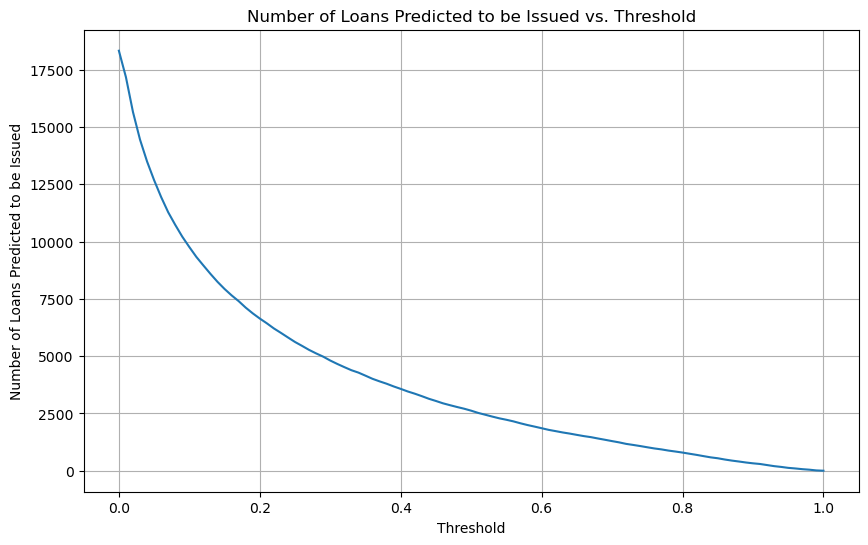

In [30]:
thresholds = np.linspace(0, 1, 101)
issued_counts = []

for threshold in thresholds:
    X_train['predicted_issued'] = X_train['probabilities'] >= threshold
    issued_count = X_train['predicted_issued'].sum()  
    issued_counts.append(issued_count)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, issued_counts)
plt.title('Number of Loans Predicted to be Issued vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Loans Predicted to be Issued')
plt.grid(True)
plt.show()


In [31]:
X_train.head()

,loan_amnt,loan_int_rate,loan_percent_income,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_PERSONAL,loan_intent_VENTURE,actual,prediction_probability,predicted_issued,gain_loss,probabilities
7573,8875,7.51,0.23,False,False,False,False,False,0,0.105087,False,0,0.105087
15865,15000,7.66,0.14,False,False,False,False,False,0,0.023507,False,0,0.023507
18729,7200,7.88,0.12,False,False,False,True,False,0,0.022012,False,0,0.022012
1288,3200,8.00,0.07,False,True,False,False,False,0,0.061475,False,0,0.061475
12168,10500,16.32,0.23,False,True,False,False,True,0,0.600637,False,0,0.600637


In [32]:
# Estimating the profit here into rows 

thresholds = np.linspace(0, 1, 101)
average_gains = []

for threshold in thresholds:
    X_train['predicted_issued'] = X_train['prediction_probability'] >= threshold
    X_train['gain_loss'] = X_train.apply(calculate_gain_loss, axis=1)
    average_gain_loss_per_issued_loan = X_train.loc[X_train['predicted_issued'], 'gain_loss'].mean()
    average_gains.append(average_gain_loss_per_issued_loan)


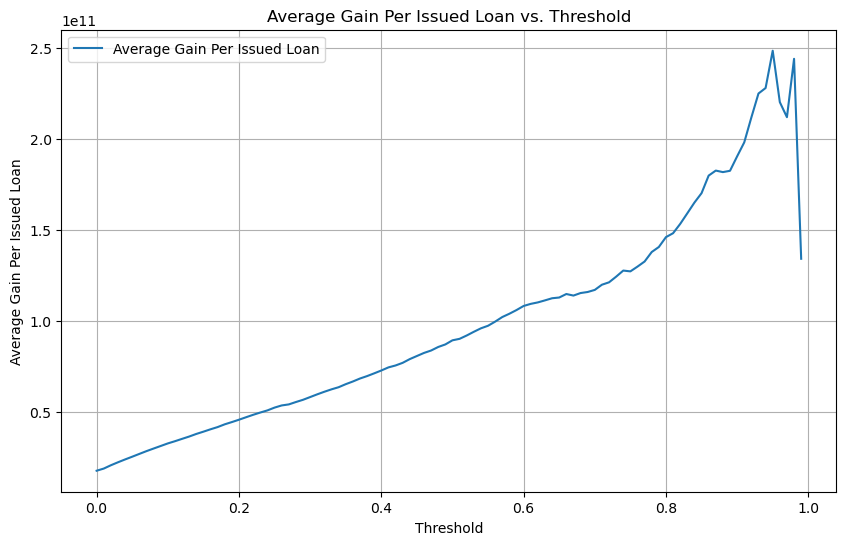

In [33]:
# Plotting the average gain per issued loan across thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, average_gains, label='Average Gain Per Issued Loan')
plt.xlabel('Threshold')
plt.ylabel('Average Gain Per Issued Loan')
plt.title('Average Gain Per Issued Loan vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

## Cross Validation

I did not want to limit myself to only one model however, so I used `cross_val_score` from the `sklearn.model_selection` in order to compare how my 'Optimal' LR model did against other LR models with a different combination of features.

In [70]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

selected_features = ['loan_amnt', 'loan_int_rate', 'loan_percent_income', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_PERSONAL', 'loan_intent_VENTURE']


feature_combinations = [
    ['loan_amnt', 'loan_int_rate'],  
    ['loan_percent_income', 'person_home_ownership_RENT'],  
    selected_features  
]


In [72]:
results = {}

for features in feature_combinations:
    # Scale features
    X_scaled = scaler.fit_transform(df[features])
    
    LR = LogisticRegression(max_iter=10000)
    
    cv_scores_LR = cross_val_score(LR, X_scaled, y, cv=5)
    results[str(features)] = cv_scores_LR.mean()

for combo, score in results.items():
    print(f"Features: {combo}\nCV Score (mean accuracy): {score}\n")


Features: ['loan_amnt', 'loan_int_rate']
CV Score (mean accuracy): 0.7973108709793388

Features: ['loan_percent_income', 'person_home_ownership_RENT']
CV Score (mean accuracy): 0.8471203482091736

Features: ['loan_amnt', 'loan_int_rate', 'loan_percent_income', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_PERSONAL', 'loan_intent_VENTURE']
CV Score (mean accuracy): 0.848342893535451



As seen above, the 'Optimal' feature LR model performed the best in predicting the likelihood of a default.

## Part D: Finding a Threshold 

In this section, we will be exploring how I came up with the threshold `t` that will be used for our model.

I used the `numpy` package to compute linear scores across all `n` of our training points.

I plotted the scores below in order to easily visualize this process. By gathering scores, we can easily simulate decision-making with a given threshold.

In [257]:
import numpy as np
import matplotlib.pyplot as plt

def linear_score(X, w):
    return X @ w


In [258]:
# Extracting weights 
w = model.coef_.flatten()  


In [259]:

scores = linear_score(X_train_selected, w) 


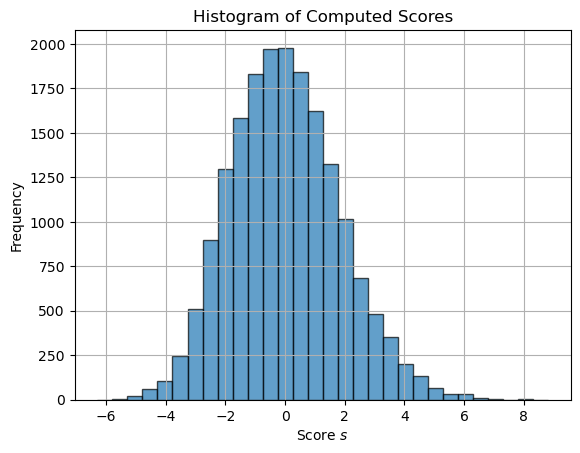

In [260]:
#| label: fig-hist-score
#| fig-cap: Histogram of Computed Scores

plt.hist(scores, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel(r"Score $s$")
plt.ylabel("Frequency")
plt.title("Histogram of Computed Scores")
plt.grid(True)
plt.show()


# ROC Curve 

Next we created an ROC curve in order to illustrate all the possible tradeoffs between the True Positive Rate and False Positive Rate that are achievable for a given score as we vary the threshold `t`

In [261]:
import numpy as np
import matplotlib.pyplot as plt

num_thresholds = 101
FPR = np.zeros(num_thresholds)
TPR = np.zeros(num_thresholds)

T = np.linspace(scores.min() - 0.1, scores.max() + 0.1, num_thresholds)

for i in range(num_thresholds):
    t = T[i]
    preds = scores >= t
    FPR[i] = ((preds == 1) & (y_train == 0)).sum() / (y_train == 0).sum()
    TPR[i] = ((preds == 1) & (y_train == 1)).sum() / (y_train == 1).sum()


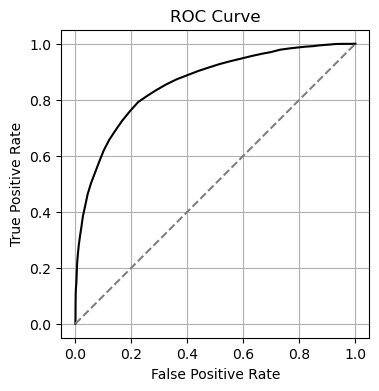

In [262]:
#| label: fig-ROC
#| fig-cap: ROC curve for Model

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(FPR, TPR, color="black")
ax.plot([0, 1], [0, 1], linestyle="--", color="grey")  
ax.set_aspect('equal')

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve")

plt.grid(True)
plt.show()


As seen in @fig-ROC, our curve bows towards the top left of the plot. Indicating that our model is a more effective classifier. 

For a reference curves that bow towards the top left of the plot are seen as more effective classifiers and those that bow inwards are seen as less effective classifiers.

## Evaluate Different Thresholds

Although the previous data from @fig-hist-score and @fig-ROC are useful, often times banks want to set a threshold that maximizes profit-loss. 

We use a two assumptions below to account for the profit and loss of a bank if a loan is repaid in full and if a loan is defaulted on. 

We then calculate the expected profit per loan for each threshold, and find the threshold that is the most optimal for generating overall profit.

This relationship is illustrated in @fig-thres.


In [273]:
def profit_repaid(loan_amnt, loan_int_rate):
    return loan_amnt * (1 + 0.25 * loan_int_rate)**10 - loan_amnt

def loss_default(loan_amnt, loan_int_rate):
    return loan_amnt * (1 + 0.25 * loan_int_rate)**3 - 20 * loan_amnt


In [278]:

probabilities = model.predict_proba(X_train_scaled)[:, 1]

expected_gains = []
T = np.linspace(0, 1, 101)  

for t in T:
    total_gain = 0
    loans_issued = 0
    
    for actual, pred_prob, amt, rate in zip(y_train, probabilities, X_train['loan_amnt'], X_train['loan_int_rate']):
        is_issued = pred_prob >= t
        if is_issued:
            loans_issued += 1
            if actual == 1:  # Loan is repaid
                total_gain += profit_repaid(amt, rate)
            else:  # Loan defaults
                total_gain += loss_default(amt, rate)
    
    avg_gain = total_gain / loans_issued if loans_issued > 0 else 0
    expected_gains.append(avg_gain)



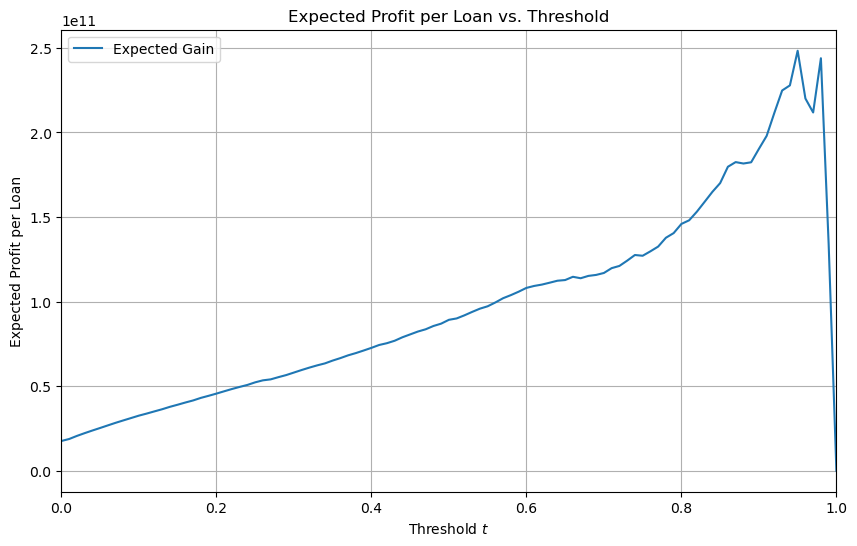

In [279]:
#| label: fig-thres
#| fig-cap: Expected Profit per Loan vs Threshold 

plt.figure(figsize=(10, 6))
plt.plot(T, expected_gains, label='Expected Gain')
plt.xlabel(r"Threshold $t$")
plt.ylabel("Expected Profit per Loan")
plt.title("Expected Profit per Loan vs. Threshold")
plt.xlim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


In [280]:
# Identify the refined optimal threshold
optimal_index = np.argmax(expected_gains)
optimal_threshold = T[optimal_index]
optimal_gain = expected_gains[optimal_index]

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Maximum Expected Gain per Loan at Optimal Threshold: {optimal_gain}")

Optimal Threshold: 0.9500000000000001
Maximum Expected Gain per Loan at Optimal Threshold: 248286039253.16788
